# ADAGE: Neuroimmunology

This script trains a denoising autoencoder for gene expression data using Keras. It modifies the framework presented by the ADAGE (Analysis using denoising autoencoders of gene expression) model published by [Tan _et al_ 2015](https://doi.org/10.1128/mSystems.00025-15).

An ADAGE model learns a non-linear, reduced dimensional representation of gene expression data by bottlenecking raw features into a smaller set. The model is then trained by minimizing the information lost between input and reconstructed input.

The specific model trained in this notebook consists of gene expression input (5000 most variably expressed genes by median absolute deviation) compressed down into one length 100 vector. The hidden layer is then decoded back to the original 5000 dimensions. The encoding (compression) layer has a `relu` activation and the decoding layer has a `sigmoid` activation. The weights of each layer are glorot uniform initialized. We include an l1 regularization term (see [`keras.regularizers.l1`](https://keras.io/regularizers/) for more details) to induce sparsity in the model, as well as a term controlling the probability of input feature dropout. This is only active during training and is the denoising aspect of the model. See [`keras.layers.noise.Dropout`](https://keras.io/layers/core/) for more details.

We train the autoencoder with the Adadelta optimizer and MSE reconstruction loss.

Reference: G. Way, Greene Lab, University of Pennsylvania

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
#import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.layers import Input, Dense, Dropout, Activation
from keras.layers.noise import GaussianDropout
from keras.models import Model
from keras.regularizers import l1
from keras import optimizers
import keras

In [5]:
print(keras.__version__)

2.0.8


In [6]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [7]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

In [8]:
import os
os.chdir('/Users/caitdreisbach/Dropbox (Personal)/Autoencoder')

In [9]:
# Load RNAseq data
rnaseq_df = pd.read_csv("Lun_cortex.csv", index_col=False) 

In [11]:
# Investigate RNAseq dataset
print(rnaseq_df.shape)
rnaseq_df.head(2)

(1599, 8857)


,X,cell_id,level1class,tissue,age,sex,Tspan12,Tshz1,Fnbp1l,Cldn12,...,Phka2,Cdkl5,Rbbp7,Syap1,Ctps2,Trappc2,Rab9,Msl3,Vamp7,Uty
0,V3,1772071015_C02,interneurons,sscortex,21,1,0.0,1.600423,1.600423,0.746262,...,0.000000,0.00000,0.746262,0.000000,0.746262,0.746262,2.521575,0.0,2.133302,0.0
1,V4,1772071017_G12,interneurons,sscortex,20,-1,0.0,0.732818,0.732818,0.732818,...,0.732818,1.86692,1.216464,0.732818,0.000000,0.732818,0.732818,0.0,0.000000,0.0


In [24]:
#drop metadata columns
rnaseq_df = rnaseq_df.drop(rnaseq_df.columns[[0, 1, 2, 3, 4, 5]], axis=1)  # df.columns is zero-based pd.Index 

In [34]:
#need to normalize gene expression values to between 0 and 1.
rnaseq_df = rnaseq_df.astype('float64') / 14.29346724
rnaseq_df.head(2)

,Tspan12,Tshz1,Fnbp1l,Cldn12,Sema3c,Jam2,BC005764,Klhl13,Tnfaip8l3,Atp1b2,...,Phka2,Cdkl5,Rbbp7,Syap1,Ctps2,Trappc2,Rab9,Msl3,Vamp7,Uty
0,0.0,0.111969,0.111969,0.052210,0.215432,0.05221,0.000000,0.111969,0.0,0.197797,...,0.000000,0.000000,0.052210,0.000000,0.05221,0.052210,0.176415,0.0,0.14925,0.0
1,0.0,0.051269,0.051269,0.051269,0.000000,0.00000,0.110403,0.085106,0.0,0.147444,...,0.051269,0.130614,0.085106,0.051269,0.00000,0.051269,0.051269,0.0,0.00000,0.0


In [35]:
np.random.seed(123)

In [36]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

## Parameter Sweep Results

We previously performed a parameter sweep search over a grid of potential hyperparameter values. Based on this sweep, we determined that the optimal ADAGE parameters are:

| Parameter | Optimal Setting |
| :-------: | :-------------: |
| Learning Rate | 1.1 |
| Sparsity | 0 |
| Noise | 0.05 |
| Epochs | 100 |
| Batch Size | 50 |

In [37]:
num_features = rnaseq_df.shape[1]
encoding_dim = 100
sparsity = 0
noise = 0.05
epochs = 100
batch_size = 50
learning_rate = 1.1

In [38]:
# Build the Keras graph
input_rnaseq = Input(shape=(num_features, ))
encoded_rnaseq = Dropout(noise)(input_rnaseq)
encoded_rnaseq_2 = Dense(encoding_dim,
                         activity_regularizer=l1(sparsity))(encoded_rnaseq)
activation = Activation('relu')(encoded_rnaseq_2)
decoded_rnaseq = Dense(num_features, activation='sigmoid')(activation)

autoencoder = Model(input_rnaseq, decoded_rnaseq)

In [39]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 8851)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8851)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               885200    
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 8851)              893951    
Total params: 1,779,151
Trainable params: 1,779,151
Non-trainable params: 0
_________________________________________________________________


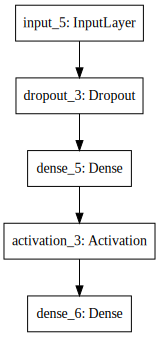

In [40]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('adage_architecture.png')

plot_model(autoencoder, to_file=output_model_file)

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [41]:
# Separate out the encoder and decoder model
encoder = Model(input_rnaseq, encoded_rnaseq_2)

encoded_input = Input(shape=(encoding_dim, ))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [42]:
# Compile the autoencoder to prepare for training
adadelta = optimizers.Adadelta(lr=learning_rate)
autoencoder.compile(optimizer=adadelta, loss='mse')

In [43]:
%%time
hist = autoencoder.fit(np.array(rnaseq_train_df), np.array(rnaseq_train_df),
                       shuffle=True,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)))

Train on 1439 samples, validate on 160 samples
Epoch 1/100
1439/1439 [==============================] - 2s - loss: 0.2114 - val_loss: 0.2120
Epoch 2/100
1439/1439 [==============================] - 2s - loss: 0.2109 - val_loss: 0.2115
Epoch 3/100
1439/1439 [==============================] - 2s - loss: 0.2102 - val_loss: 0.2105
Epoch 4/100
1439/1439 [==============================] - 2s - loss: 0.2087 - val_loss: 0.2083
Epoch 5/100
1439/1439 [==============================] - 2s - loss: 0.2053 - val_loss: 0.2032
Epoch 6/100
1439/1439 [==============================] - 2s - loss: 0.1975 - val_loss: 0.1918
Epoch 7/100
1439/1439 [==============================] - 2s - loss: 0.1808 - val_loss: 0.1683
Epoch 8/100
1439/1439 [==============================] - 2s - loss: 0.1497 - val_loss: 0.1293
Epoch 9/100
1439/1439 [==============================] - 2s - loss: 0.1062 - val_loss: 0.0841
Epoch 10/100
1439/1439 [==============================] - 2s - loss: 0.0652 - val_loss: 0.0500
Epoch 11/100

1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 87/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 88/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 89/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 90/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 91/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 92/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 93/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 94/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 95/100
1439/1439 [==============================] - 2s - loss: 0.0050 - val_loss: 0.0053
Epoch 96/100
1439/1439 [==============================] - 2s - 

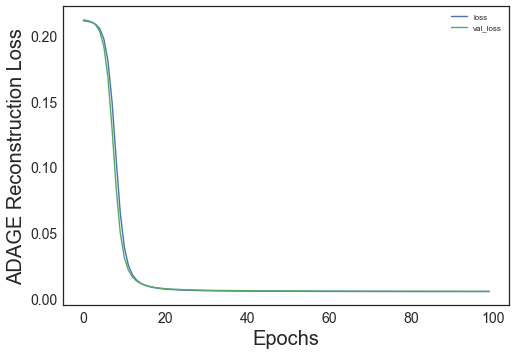

In [44]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('adage_training.png')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('ADAGE Reconstruction Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

### Save Model Outputs

In [57]:
# Encode rnaseq into the hidden/latent representation - and save output
encoded_samples = encoder.predict(np.array(rnaseq_df))
encoded_rnaseq_df = pd.DataFrame(encoded_samples, index=rnaseq_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_file = os.path.join('encoded_adage_features.tsv')
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

In [58]:
# Output weight matrix of gene contributions per node
weight_file = os.path.join('adage_gene_weights.tsv')

weight_matrix = pd.DataFrame(autoencoder.get_weights()[0], index=rnaseq_df.columns,
                             columns=range(1, 101)).T
weight_matrix.index.name = 'encodings'
weight_matrix.to_csv(weight_file, sep='\t')

## Observe reconstruction

In [49]:
# Reconstruct input RNAseq
decoded_samples = decoder.predict(encoded_samples)

reconstructed_df = pd.DataFrame(decoded_samples, index=rnaseq_df.index,
                                columns=rnaseq_df.columns)

In [50]:
reconstruction_fidelity = rnaseq_df - reconstructed_df

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
Plp1,-0.014648,0.261488
Trf,-0.007032,0.247301
Mal,-0.000214,0.229209
Apod,-0.002573,0.224493
Mog,-0.003362,0.224451


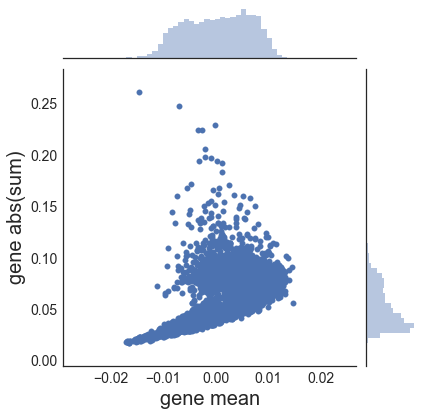

In [52]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
reconstruct_fig_file = os.path.join('adage_gene_reconstruction.png')
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);
g.savefig(reconstruct_fig_file)

In [59]:
# What are the most and least activated nodes
sum_node_activity = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)

# Top 5 most active nodes
print(sum_node_activity.head(5))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
73    28771.302734
28    23082.771484
84    22069.566406
79    19161.257812
41    18446.765625
dtype: float32


sample_id
14   -236.697021
74   -245.223984
92   -248.392059
33   -260.712036
24   -283.123688
19   -288.158325
63   -293.836945
95   -296.285736
48   -321.245026
85   -336.834991
dtype: float32

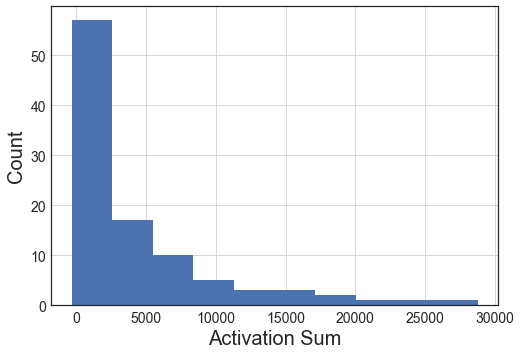

In [54]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');

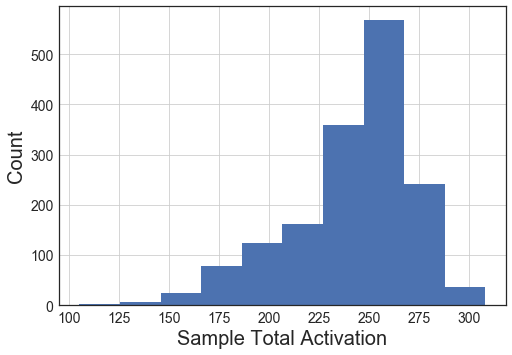

In [55]:
# Histogram of sample activity for all 10,000 samples
encoded_rnaseq_df.sum(axis=1).hist()
plt.xlabel('Sample Total Activation')
plt.ylabel('Count');

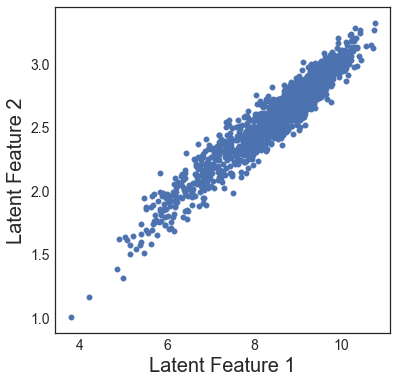

In [56]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 1], encoded_rnaseq_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2');

In [60]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=rnaseq_df.index,
                                        columns=rnaseq_df.columns)
input_rnaseq_reconstruct.head(2)

,Tspan12,Tshz1,Fnbp1l,Cldn12,Sema3c,Jam2,BC005764,Klhl13,Tnfaip8l3,Atp1b2,...,Phka2,Cdkl5,Rbbp7,Syap1,Ctps2,Trappc2,Rab9,Msl3,Vamp7,Uty
0,0.019162,0.024121,0.035564,0.020632,0.027765,0.019612,0.016500,0.019509,0.014485,0.054063,...,0.017048,0.021317,0.039337,0.020351,0.019733,0.051962,0.072855,0.019812,0.053245,0.014956
1,0.020204,0.025293,0.036900,0.021375,0.028361,0.020664,0.017403,0.020756,0.015173,0.056262,...,0.017943,0.021953,0.040127,0.020990,0.020133,0.054454,0.073062,0.020634,0.055282,0.015963


In [61]:
reconstruction_fidelity = rnaseq_df - input_rnaseq_reconstruct

gene_mean = reconstruction_fidelity.mean(axis=0)
gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
gene_summary = pd.DataFrame([gene_mean, gene_abssum], index=['gene mean', 'gene abs(sum)']).T
gene_summary.sort_values(by='gene abs(sum)', ascending=False).head()

,gene mean,gene abs(sum)
Plp1,-0.014648,0.261488
Trf,-0.007032,0.247301
Mal,-0.000214,0.229209
Apod,-0.002573,0.224493
Mog,-0.003362,0.224451


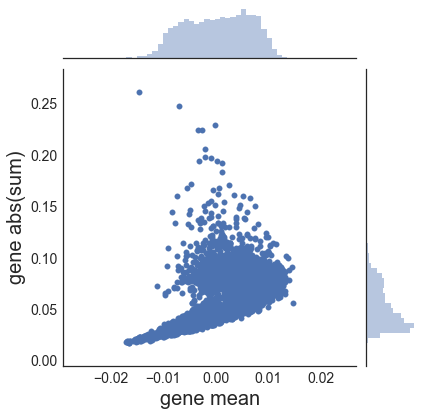

In [62]:
# Mean of gene reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('gene mean', 'gene abs(sum)', data=gene_summary, stat_func=None);